In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

dr_name=[]
fl_names=[]
fl_name=[]
path=[]
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    dr_name.append(dirname)
    fl_names.append(filenames)
    
    for filename in filenames:
        fl_name.append(filename)
        a=os.path.join(dirname, filename)
        path.append(a)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import itertools

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

In [52]:
df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [53]:
df[df['image_id']=='ISIC_0031633']

,lesion_id,image_id,dx,dx_type,age,sex,localization
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [54]:
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [55]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [56]:
df['dx']

0          bkl
1          bkl
2          bkl
3          bkl
4          bkl
         ...  
10010    akiec
10011    akiec
10012    akiec
10013    akiec
10014      mel
Name: dx, Length: 10015, dtype: object

In [57]:
labels_dictionary_dx_num = {'nv':0, 'mel':1, 'bkl':2, 'bcc':3, 'akiec':4, 'vasc':5, 'df':6}


In [58]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [59]:
base_skin_dir = '../input/skin-cancer-mnist-ham10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}
print(type(imageid_path_dict))

<class 'dict'>


In [60]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

print(df['path'][10],"   ",df['image_id'][10])
print(len(df['path']))


../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0025276.jpg     ISIC_0025276
10015


In [61]:
from PIL import Image as pl
im = pl.open("../input/skin-cancer-mnist-ham10000/ham10000_images_part_1/ISIC_0025276.jpg")
im=np.array(im)
print(im.shape)

(450, 600, 3)


In [62]:
labels = [labels_dictionary_dx_num[i] for i in df['dx']]
print(len(labels))

10015


In [63]:
df.isna().sum()
df['age'].fillna((df['age'].mean()), inplace=True)
df.isna().sum().sum()


0

In [64]:
from PIL import Image
print(len(df['path']))
from PIL import Image
print(len(df['path']))
data = []

for image_path in df['path']:
    
    image = Image.open(image_path)
        
    image_resised_71_71=image.resize((71,71))
    image_resised_71_71 = np.array(image_resised_71_71)
#     image_resised_224_224=image.resize((224,224))
#     image_resised_224_224=np.array(image_resised_224_224)
#     image_resised_256_256=image.resize((256,256))
#     image_resised_100_100 = np.array(image_resised_100_100)
#     image_resised_224_224 = np.array(image_resised_224_224)
#     image_resised_256_256 = np.array(image_resised_256_256)
#     image_resised_128_128=image.resize((128,128))
#     image_resised_128_128 = np.array(image_resised_128_128)
    data.append(image_resised_71_71)

10015
10015


In [65]:
print(df['path'])

0        ../input/skin-cancer-mnist-ham10000/ham10000_i...
1        ../input/skin-cancer-mnist-ham10000/ham10000_i...
2        ../input/skin-cancer-mnist-ham10000/ham10000_i...
3        ../input/skin-cancer-mnist-ham10000/ham10000_i...
4        ../input/skin-cancer-mnist-ham10000/ham10000_i...
                               ...                        
10010    ../input/skin-cancer-mnist-ham10000/ham10000_i...
10011    ../input/skin-cancer-mnist-ham10000/ham10000_i...
10012    ../input/skin-cancer-mnist-ham10000/ham10000_i...
10013    ../input/skin-cancer-mnist-ham10000/ham10000_i...
10014    ../input/skin-cancer-mnist-ham10000/ham10000_i...
Name: path, Length: 10015, dtype: object


In [66]:
print(len(data))
print(len(labels))
print(data[0].shape)
print(data[5].shape)

10015
10015
(71, 71, 3)
(71, 71, 3)


In [67]:
data=np.array(data)
labels=np.array(labels)
print(data.shape)
print(labels.shape)

(10015, 71, 71, 3)
(10015,)


In [68]:
X_train,X_test,Y_train,Y_test = train_test_split(data, labels, test_size=0.2, random_state=49)

In [69]:
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)
print(Y_test.shape)

(8012, 71, 71, 3)
(2003, 71, 71, 3)
(2003,)
(2003,)


In [74]:
from imblearn.over_sampling import RandomOverSampler 
print(data.shape,labels.shape)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

# # To overcome class imbalace
oversample = RandomOverSampler()
Data,Label  = oversample.fit_resample(X_train,Y_train)
print(Data.shape,Label.shape)

(10015, 71, 71, 3) (10015,)
(8012, 71, 71, 3) (8012,)
(2003, 71, 71, 3) (2003,)


ValueError: Found array with dim 4. RandomOverSampler expected <= 2.

In [75]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# num_of_classes = 7

# # setting up the layers of Neural Network

# model = keras.Sequential([
    
#     keras.layers.Flatten(input_shape=(128,128,3)),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(num_of_classes, activation='softmax')
# ])

In [ ]:
# import tensorflow as tf
# from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.utils import to_categorical

# # Define the input image size
# input_shape = (71, 71, 3)

# # Preprocess the input images
# X_train = preprocess_input(X_train)
# X_test = preprocess_input(X_test)

# # Convert target labels to one-hot vectors
# Y_train = to_categorical(Y_train)
# Y_test = to_categorical(Y_test)

# # Create an instance of the DenseNet-201 model
# base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze the pre-trained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Add custom layers on top of the pre-trained base model
# model = tf.keras.models.Sequential()
# model.add(base_model)
# model.add(tf.keras.layers.GlobalAveragePooling2D())
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.5))
# model.add(tf.keras.layers.Dense(7, activation='softmax'))  # num_classes is the number of output classes

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define data augmentation for training data
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Train the model
# batch_size = 64
# epochs = 100

# history = model.fit(
#     datagen.flow(X_train, Y_train, batch_size=batch_size),
#     steps_per_epoch=len(X_train) // batch_size,
#     epochs=epochs,
#     validation_data=(X_test, Y_test)
# )




In [ ]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, Y_test)
# print("Test loss:", loss)
# print("Test accuracy:", accuracy)

In [76]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Define the input image size
input_shape = (71, 71, 3)

# Preprocess the input images
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

# Convert target labels to one-hot vectors
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(71, 71, 3))

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        layer.kernel_size = (5, 5)
        layer.padding = 'same'

base_model.layers.pop()


num_classes = 7  # Change this to the number of classes in your task

model1 = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.5),  # Dropout layer with rate 0.5

    tf.keras.layers.Dense(num_classes, activation='softmax')
])
learning_rate = 0.0001  # Change this to your desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [77]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto')

In [78]:
# Define data augmentation for training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Train the model
batch_size = 64
epochs = 10

history = model1.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_test, Y_test)
)

Epoch 1/10
125/125 [==============================] - 148s 269ms/step - loss: 1.1679 - accuracy: 0.6415 - val_loss: 0.9423 - val_accuracy: 0.7104
Epoch 2/10
125/125 [==============================] - 25s 198ms/step - loss: 0.7082 - accuracy: 0.7484 - val_loss: 0.7532 - val_accuracy: 0.7614
Epoch 3/10
125/125 [==============================] - 24s 191ms/step - loss: 0.5860 - accuracy: 0.7893 - val_loss: 0.5676 - val_accuracy: 0.7973
Epoch 4/10
125/125 [==============================] - 23s 186ms/step - loss: 0.5349 - accuracy: 0.8011 - val_loss: 0.5551 - val_accuracy: 0.7988
Epoch 5/10
125/125 [==============================] - 24s 191ms/step - loss: 0.4847 - accuracy: 0.8228 - val_loss: 0.5387 - val_accuracy: 0.8008
Epoch 6/10
125/125 [==============================] - 25s 199ms/step - loss: 0.4720 - accuracy: 0.8283 - val_loss: 0.5435 - val_accuracy: 0.8008
Epoch 7/10
125/125 [==============================] - 25s 200ms/step - loss: 0.4298 - accuracy: 0.8442 - val_loss: 0.5533 - val_a

In [79]:
results = model1.evaluate(X_test , Y_test, verbose=0)

print("DenseNet 201 Test Results")
print("        Test Loss: {:.5f}".format(results[0]))
print("    Test Accuracy: {:.2f}%".format(results[1] * 100))

DenseNet 201 Test Results
        Test Loss: 0.58677
    Test Accuracy: 81.23%


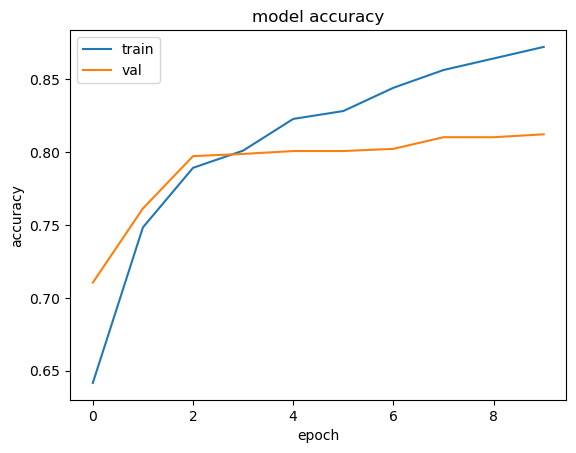

In [80]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

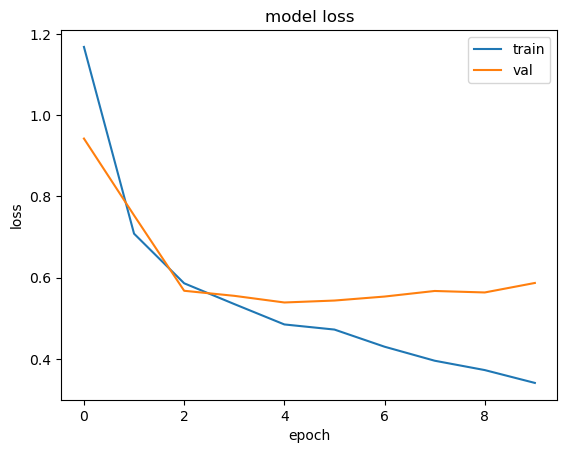

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [82]:
from sklearn.metrics import confusion_matrix , classification_report

y_true_CNN = list(Y_test)
y_pred_CNN = model1.predict(X_test)
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("Predicting First Ten Rows:")
print('Y Actual Values :' , y_true_CNN[0:10])
print('Y Predicted Values :' , y_pred_CNN[0:10])

63/63 [==============================] - 5s 27ms/step
Predicting First Ten Rows:
Y Actual Values : [array([0., 1., 0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 1., 0., 0.], dtype=float32), array([0., 1., 0., 0., 0., 0., 0.], dtype=float32), array([0., 1., 0., 0., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32), array([0., 0., 1., 0., 0., 0., 0.], dtype=float32), array([0., 0., 1., 0., 0., 0., 0.], dtype=float32), array([0., 0., 1., 0., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
Y Predicted Values : [1, 4, 0, 2, 0, 2, 0, 2, 0, 1]


In [85]:
cm_CNN = confusion_matrix(y_true_CNN,y_pred_CNN,labels=labels)
print(confusion_matrix(y_true_CNN,y_pred_CNN,labels=labels))
sns.heatmap(cm_CNN, annot = True, fmt='')

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [ ]:
#training acc vs testing acc graph
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

In [ ]:
#predicting
y_pred_CNN  = model1.predict(X_test)
target_names = [f"{classes[i]}" for i in range(7)]
y_pred_CNN = list(map(lambda x: np.argmax(x), y_pred_CNN))
print("CNN Model Prediction Results")
print(classification_report(Y_test , y_pred_CNN,target_names=target_names))

In [ ]:
# Layers definitions
from keras import backend as K
for l in range(len(model1.layers)):
    print(l, model1.layers[l])

In [ ]:
model1.layers[-2]
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
kerasBKED = os.environ["KERAS_BACKEND"] 
print(kerasBKED)

In [ ]:
import tensorflow as tf
# feature_extractor = tf.keras.Model(inputs=model_CNN.input, 
#                                     outputs=model_CNN.get_layer(-2).output)
# output_layers_model =tf.keras.Model(inputs=model_CNN.input, outputs=model_CNN.output)
# cnn_layer_output = model_CNN.layers[-2].output
# cnn_model_features = tf.keras.Model(inputs=model_CNN.input, outputs=cnn_layer_output)
cnn_model_features = tf.keras.Model(inputs=model1.input, outputs=model1.layers[-3].output)

In [71]:
# Extract features from input data using the CNN model
X_train_cnn = cnn_model_features.predict(X_train)
X_test_cnn = cnn_model_features.predict(X_test)

NameError: name 'cnn_model_features' is not defined

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(X_train_cnn, Y_train)
# Evaluate the combined CNN-SVM model on a test dataset
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
y_testSVM = clf.predict(X_test_cnn)

In [ ]:
svm_accuracy = clf.score(X_test_cnn, Y_test)
print('SVM Accuracy:', svm_accuracy*100)
svmclf = clf.best_estimator_
print(svmclf)
svmclf.fit(X_train_cnn, Y_train)
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))

In [ ]:
y_testSVM = svmclf.predict(X_test_cnn)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print(classification_report(Y_test, y_testSVM,target_names=target_names))
print("Accuracy: {0}".format(accuracy_score(Y_test, y_testSVM)*100))